# Global analysis

In this section, We aim to perform a global causal analysis of the relationships between our **performance metrics: average rating, movie box office** and our **diversity metrics: Simpson gender, ethnical diversity**. We do this by performing a propensity score matching such that identified confouders: number of translated languages, release year and movie genre have the same distributions for movies that are considered diverse(treatment) and movies with a more homogeneous cast(control). Each subsections consists in the analysis of a performance variable against a diversity one.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import networkx as nx
import networkit as nk
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from src.helpers import *
pd.options.mode.chained_assignment = None  

## Handling data

Firstly, we import the two dataframes that were processed for this task: `gender diversity` and `ethnicity diversity` and filter some NaN values that were not impending previous analyses.  

In [ ]:
# csv files paths
gen_data_dir = './generated/'
gender_diversity_file = gen_data_dir + 'gender_diversity.csv'
ethnicity_diversity_file = gen_data_dir + 'ethnicity_diversity.csv'

# Load generated datasets
gender_diverity_df = pd.read_csv(gender_diversity_file)
ethnicity_diversity_df = pd.read_csv(ethnicity_diversity_file)

In [ ]:
gender_diverity_df.head()

In [ ]:
ethnicity_diversity_df.head()

In [102]:
#Filter out movies with no release year
enthnicity_df_filtered = ethnicity_diversity_df.dropna(subset='movie_release_year').copy()
gender_df_filtered = gender_diverity_df.dropna(subset='movie_release_year').copy()
print('ethnicity dataframe : \n\tlen before dropping : {}\n\tlen after dropping : {}'.format(len(ethnicity_diversity_df),len(enthnicity_df_filtered)))
print('gender dataframe : \n\tlen before dropping : {}\n\tlen after dropping : {}'.format(len(gender_diverity_df),len(gender_df_filtered)))

ethnicity dataframe : 
	len before dropping : 12640
	len after dropping : 12513
gender dataframe : 
	len before dropping : 29887
	len after dropping : 29224


In [96]:
## Now we define some utility functions
def common_movie_genre(str1, str2, similarity_rate = 1.):  #check if two movies have at least one common genre
    """Parses and compare two sets of movie genres and returns true if, given a certain threshold, movie genres are
       considered to match and return False otherwise.

    Args:
        str1 (str): First movie genre string. 
        str2 (str): Second movie genre string.
        similarity_rate (float, optional): proportion of the genre set with the highest number of elements that are
                                           considered as a match.

    Returns:
        bool: True if enough genres are matching, otherwise false
    """    
    list1 = [genre.strip() for genre in str1.strip("[]").split(",")]
    list2 = [genre.strip() for genre in str2.strip("[]").split(",")]

    set1 = set(list1)
    set2 = set(list2)
    intersection_set = len(set1.intersection(set2))

    if intersection_set/max([len(set1),len(set2)]) >= similarity_rate:
        return True
    else:
        return False
    

def match_on_attributes(sample1, sample2):
    """Determines exact matching between two samples of the movie dataset based on genre.

    Args:
        sample1 (pd.Series): First sample to match
        sample2 (pd.Series): Second sample to match

    Returns:
        bool: Returns true if the samples can be matched, false otherwise
    """    
    cond = True
    cond = cond & common_movie_genre(sample1['movie_genres'],sample2['movie_genres'], similarity_rate=1/2)
    return cond

    

def add_propensity_score(df, formula):
    """Fits a linear regressor to a dataframe given a formula to compute propensity scores.

    Args:
        df (pd.Dataframe): Data on which the regression is made.
        formula (string): logical formula used for the linear regressor

    Returns:
        pd.Dataframe: _description_
    """
    #df = standardize_continuous_features(df)
    mod = smf.ols(formula= formula, data=df)
    res = mod.fit()
    df['Propensity_score'] = res.predict()
    return df

def get_similarity(propensity_score1, propensity_score2):
    '''Computes a similarity metric based on propensity scores of two samples.
       Similar elements will have a value close to 1 and different ones close to 0'''
    return 1-np.abs(propensity_score1-propensity_score2)


def filtering(df, performance_param):
    """Filters NaN values in dataframe for performance variables.

    Args:
        df (pd.Dataframe): dataframe with the values to filter
        performance_param (string): name of the columns/variable to filter

    Returns:
        pd.Dataframe: Dataframe filtered based on the performance variables 
    """    
    df_copy = df.copy()
    if (performance_param == 'movie_box_office_revenue'):
        df_copy.dropna(subset=['movie_box_office_revenue'],inplace=True)
        return df_copy

    elif (performance_param == 'rating_average'):
        df_copy.dropna(subset=['rating_average'],inplace=True)
        df_bis = df_copy[df_copy['rating_count'] > 100]
        return df_bis

    else:
        print("Invalid parameters")






def balanced_dataset(data, match_on, perf_var, out_df_name = None):
    """Performs the pipeline to create control and treatment groups with matching of the confounders.
       Based on the steps of Exercise 05 - Causal analysis of observational data.
       Credits to: [Tiziano Piccardi](https://piccardi.me/) and [Kristina Gligoric](https://kristinagligoric.github.io/)

    Args:
        data (pd.Dataframe): Dataframe on which the balancing needs to be performed.
        match_on (str): Diversity variable that will be used to create control and treatment variables.
        perf_var (str): Performance variable that will be used to filter the dataframe before processing.
        out_df_name (str, optional): Will save the dataset to csv if any name is provided . Defaults to None.

    Returns:
        pd.Dataframe: Dataframe of matches made based on propensity scores.
    """    
    print('filtering df')
    df = filtering(data,perf_var)

    # Define threshold depending on the input performance variable
    if match_on == 'ethnicity_diversity':
        threshold = df[match_on].median()
    elif match_on == 'gender_diversity':
        threshold = 0.35
    else:
        threshold=None
        print('Error in the feature that needs to be matched')

    # Assign control or treatment status depending on threshold
    df['treatment'] = np.where(df[match_on] > threshold, 1, 0)
    
    # Make the prediction of propensity scores using a linear regressor
    mod = smf.logit(formula= 'treatment ~ movie_release_year + movie_languages_count', data=df)
    res = mod.fit()
    df['Propensity_score'] = res.predict()
    
    print('Creating graph')
    treatment = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]

    # Generated matched pairs
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control.iterrows():
        for treatment_id, treatment_row in treatment.iterrows():
            if (match_on_attributes(control_row,treatment_row)):
                # Compute the similarity 
                similarity = get_similarity(control_row['Propensity_score'],
                                            treatment_row['Propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    print('performing matching')
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.loc[matched]
    
    # Save the balanced dataframe if a name was specified
    if out_df_name:
        print('saving file')
        file = './generated/' + out_df_name
    balanced_df.to_csv(file)
    return balanced_df

def compute_results(balanced_df, perf_var, diversity_var):
    """Plots control and treatment distributions and performs a statistical analysis using linear regression.

    Args:
        balanced_df (pd.Dataframe): Dataframe with a control and treatment group(in a 'treatment' column) and matched samples
        perf_var (str): Name of the performance variable to plot and compare with linear regression.


    Returns:
        TODO: regressive model trained on the balanced dataframe  
    """    
    treatment_balanced = balanced_df[balanced_df['treatment'] == 1]
    control_balanced = balanced_df[balanced_df['treatment'] == 0]
    mod = smf.ols(formula= '{} ~ C(treatment)'.format(perf_var), data=balanced_df)
    res = mod.fit()

    # Plot density distributions for treatment and control groups
    plt.figure()
    ax = sns.histplot(treatment_balanced[perf_var], kde=True, stat='density', color='blue', label='High diversity', log_scale=True)
    ax = sns.histplot(control_balanced[perf_var], kde=True, stat='density', color='orange', label='Low diversity',log_scale=True)
    ax.set(title='{}, after matching'.format(perf_var),xlabel='z-scored {}'.format(perf_var), ylabel='Density')
    plt.legend()

    # Scatter plot with a regression line
    intercept = mod.fit().params['Intercept']
    ethnicity_coef = mod.fit().params['C(treatment)[T.1]']
    x_values = np.linspace(min(balanced_df[diversity_var]), max(balanced_df[diversity_var]), 100)
    y_values = intercept + ethnicity_coef * x_values
    plt.figure()
    sns.scatterplot(data=balanced_df,x=diversity_var,y=perf_var, hue='treatment')
    sns.lineplot(x=x_values,y=y_values,color='red')
    plt.tight_layout()
    plt.show()
    print(res.summary())

    return mod


To define if a movie is diverse or not, which means differentiating control and treatment groups, we made the choice to perform a separation on the median point. The following plots show how these cuts cleave the two groups of data.

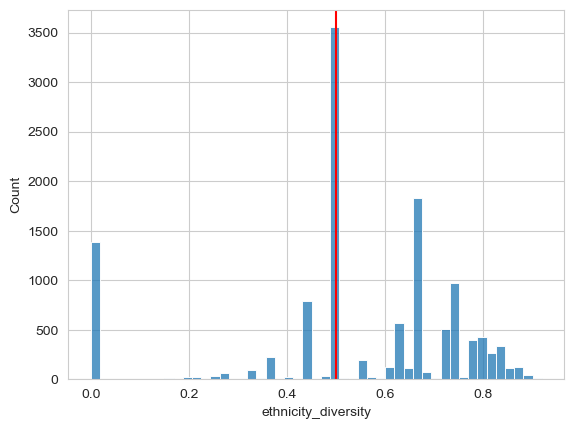

In [103]:
sns.histplot(data = enthnicity_df_filtered,x='ethnicity_diversity')
threshold_ethnicity = enthnicity_df_filtered['ethnicity_diversity'].median()
plt.axvline(x=threshold_ethnicity,c='red')
plt.show()

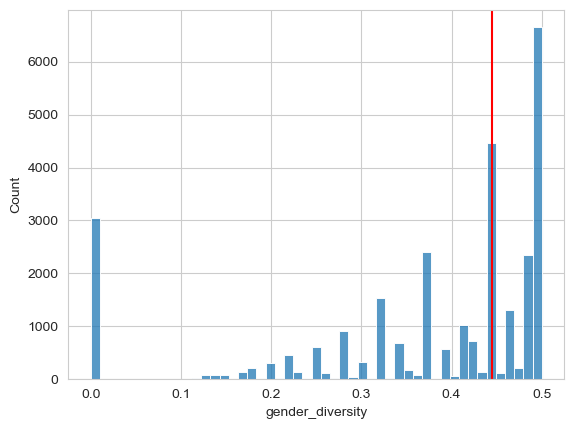

In [104]:
sns.histplot(data = gender_df_filtered,x='gender_diversity')
threshold_gender = gender_df_filtered['gender_diversity'].median() # TODO: replace with 0.3
plt.axvline(x=threshold_gender,c='red')
plt.show()

## Ethnicity to box office 

In this part, we assess the relationship between the performance feature `movie box office revenue` and the diversity feature `ethnic simpson diversity`

c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


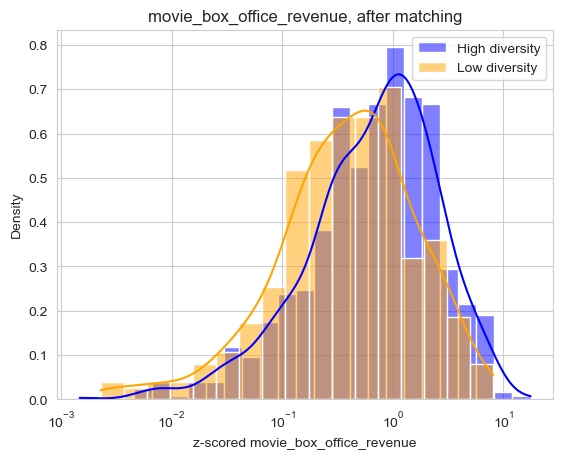

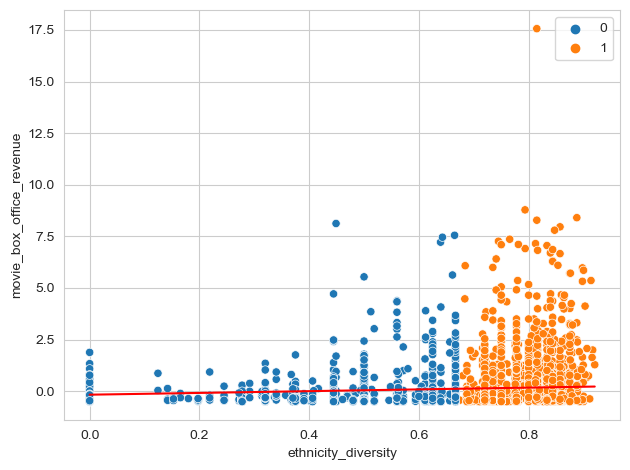

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     183.7
Date:                      Wed, 20 Dec 2023   Prob (F-statistic):           5.38e-41
Time:                              18:40:27   Log-Likelihood:                -6036.3
No. Observations:                      4190   AIC:                         1.208e+04
Df Residuals:                          4188   BIC:                         1.209e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [97]:
perf_var = 'movie_box_office_revenue'
div_var = 'ethnicity_diversity'
box_vs_ethn = balanced_dataset(data=enthnicity_df_filtered,match_on=div_var,perf_var=perf_var,out_df_name='BOR_vs_EthnDiv2')
# box_vs_ethn = pd.read_csv('./generated/BOR_vs_EthnDiv.csv')
model = compute_results(balanced_df=box_vs_ethn,perf_var=perf_var,diversity_var=div_var)


From the distribution above and statistical tests, we see that the relationship between a movie's box office performance and the fact that it received treatment(having a diverse cast), is a positive ($\beta$>0) and significant (p < 0.05) correlation. It indicates that having a diverse cast in terms of ethnicity brings a better performance in terms of success.

## Gender diversity to box office

In this part, we assess the relationship between the performance feature `movie box office revenue` and the diversity feature `gender simpson diversity`

c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


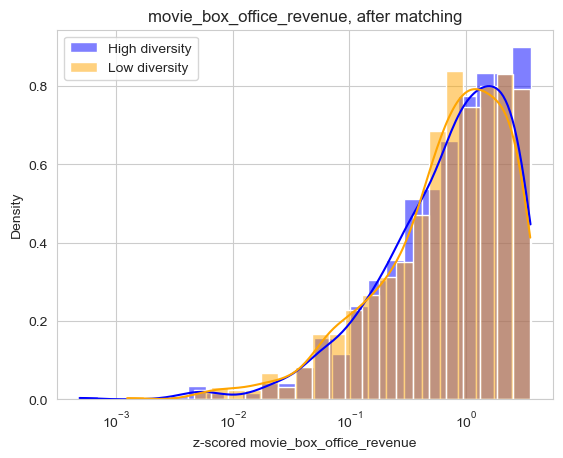

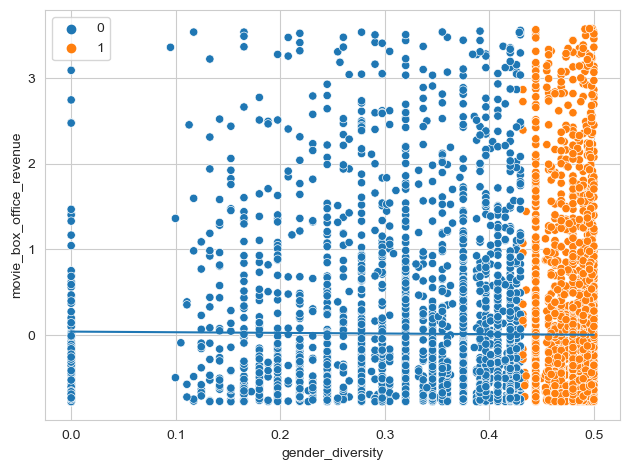

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                  0.001
Method:                       Least Squares   F-statistic:                     7.167
Date:                      Wed, 20 Dec 2023   Prob (F-statistic):            0.00745
Time:                              18:36:11   Log-Likelihood:                -7345.0
No. Observations:                      5194   AIC:                         1.469e+04
Df Residuals:                          5192   BIC:                         1.471e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [89]:
perf_var = 'movie_box_office_revenue'
div_var = 'gender_diversity'
box_vs_gen = balanced_dataset(data=gender_df_filtered,match_on=div_var,perf_var=perf_var,out_df_name='BOR_vs_GendDiv2')
# box_vs_gen = pd.read_csv('./generated/BOR_vs_GendDiv.csv')
model = compute_results(balanced_df=box_vs_gen,perf_var=perf_var,diversity_var=div_var)

From the above plot and statistical test, we can notive a few things. The relationship between movie box office revenue and having a diverse cast in terms of gender diversity seems to be negatively ($\beta$<0) correlated (p<0.05). However, we see that the correlation value is way lower than the positive correlation shown between box office revenue and ethnic diversity. Another important point to note is that the explained variance R-squared is way lower, we visually see in the plots that the distributions seem to be very close and the statistical test seems to enhance the idea that the effect is very slow and isn't a reliable explanation of variations in box office revenue.

## Ethnicity diversity to rating average

In this part, we assess the relationship between the performance feature `movie average ratings` and the diversity feature `ethnic simpson diversity`

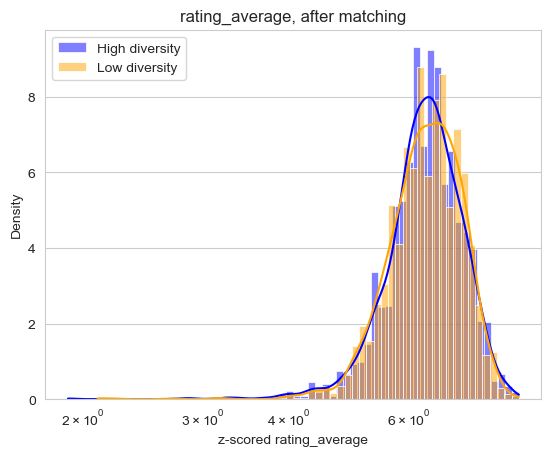

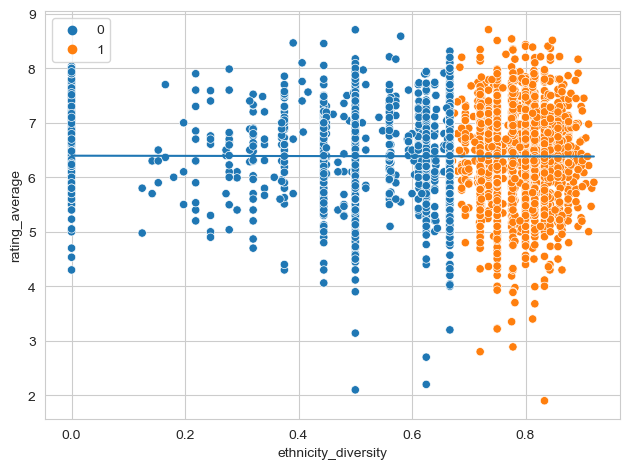

                            OLS Regression Results                            
Dep. Variable:         rating_average   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4653
Date:                Wed, 20 Dec 2023   Prob (F-statistic):              0.495
Time:                        18:36:45   Log-Likelihood:                -5101.3
No. Observations:                4388   AIC:                         1.021e+04
Df Residuals:                    4386   BIC:                         1.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.3960      0.01

In [91]:
perf_var = 'rating_average'
div_var = 'ethnicity_diversity'
rating_vs_ethn = balanced_dataset(data=enthnicity_df_filtered,match_on=div_var,perf_var=perf_var,out_df_name='AvgR_vs_EthnDiv2')
# rating_vs_ethn = pd.read_csv('./generated/AvgR_vs_EthnDiv.csv')
compute_results(balanced_df=rating_vs_ethn,perf_var=perf_var,diversity_var=div_var)

The relationship between ethnic diversity and rating averages shows a negative correlation ($\beta$<0) but this time non significant (p>0.05) and the explained variance is near to zero as well. This seems to show that there is no effect between the fact of having a diverse cast in term of ethnicity and the average ratings the movies receive

# Gender diversity to movie average

In this part, we assess the relationship between the performance feature `movie average ratings` and the diversity feature `gender simpson diversity`

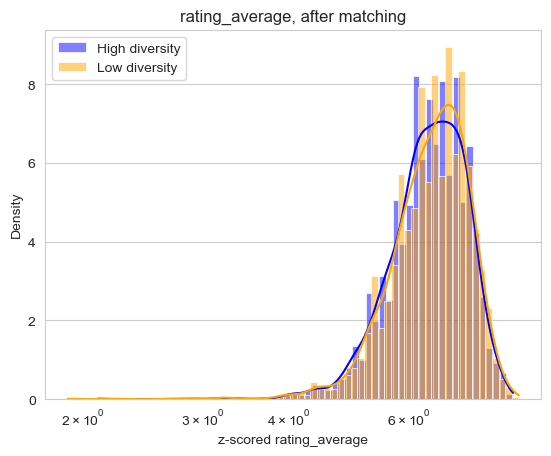

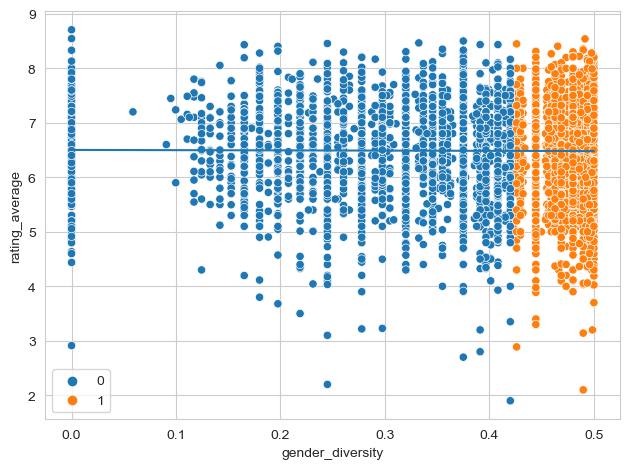

                            OLS Regression Results                            
Dep. Variable:         rating_average   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.196
Date:                Wed, 20 Dec 2023   Prob (F-statistic):             0.0406
Time:                        18:37:08   Log-Likelihood:                -7688.6
No. Observations:                6368   AIC:                         1.538e+04
Df Residuals:                    6366   BIC:                         1.539e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.5018      0.01

In [93]:
perf_var = 'rating_average'
div_var = 'gender_diversity'
rating_vs_gend = balanced_dataset(data=gender_df_filtered,match_on=div_var,perf_var=perf_var,out_df_name='AvgR_vs_GendDiv2')
# rating_vs_gend = pd.read_csv('./generated/AvgR_vs_GendDiv.csv')
compute_results(balanced_df=rating_vs_gend,perf_var=perf_var,diversity_var=div_var)

The plot and statistical analysis shows similar results than the relationship between gender and movie box office revenue. It has a slight negative significant (p<0.05) correlation that explains a very low part of the variance. One might conclude as well that the importance of gender diversity in this set of movies seem to have low to no impact on average ratings.

## Global analysis, discussion.

From a global viewpoint, the strongest relationship identified was the positive correlation between `movie box office revenue` and `ethnic diversity`. It has the highest explained variance (R=0.040) of all comparisons and a high correlation coefficient (~0.43) considering that the box office revenue variable has been normalized. \
On the other hand, we found negative a correlation between gender diversity and both performance variables but those explain a very negligible part of the variance with an effect lower by a factor 40 when considering revenue and a very small effect as well for ratings. Finally, no effect was identified between ethnic diversity and average ratings of movies.

This analysis tends to show that successful movies tend to have a more diverse ethnically diverse casts, regardless of how the number of languages the movies were translated to as well as part of the genres and release year. 